##Backtest usando fastquant



In [30]:
#instalando fastquant
!pip install fastquant

## Pega dados da Binance

In [31]:
# preço do bitcoin
from fastquant import get_crypto_data

crypto = get_crypto_data("BTC/USDT", 
                         "2020-10-01", 
                         "2021-10-31",
                         time_resolution='1h'
                        )

In [32]:
crypto.tail()

,open,high,low,close,volume
dt,,,,,
2021-10-30 20:00:00,61730.84,61960.00,61545.05,61642.11,1022.57940
2021-10-30 21:00:00,61642.10,61699.80,61426.04,61429.03,912.48687
2021-10-30 22:00:00,61429.02,61624.00,61175.01,61540.33,1810.10864
2021-10-30 23:00:00,61540.32,61900.00,61479.76,61859.19,1749.61796
2021-10-31 00:00:00,61859.19,62400.15,61859.18,62375.29,2649.54855


## Executando Backtesting com conjunto de valores

In [33]:
# Usando Cruzamento de Médias Móveis 
from fastquant import backtest

results = backtest('smac', 
                   crypto, 
                   fast_period=[7,14,21,28], 
                   slow_period=[30,45,60,75],
                   plot=False,
                   verbose=False
                  )

In [34]:
#tabela de resultados
results.head()

,strat_id,init_cash,buy_prop,sell_prop,fractional,slippage,single_position,commission,stop_loss,stop_trail,take_profit,execution_type,channel,symbol,allow_short,short_max,add_cash_amount,add_cash_freq,invest_div,fast_period,slow_period,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,3,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,75,1.379804,0.003484,1.406219,140.621943,249,7.302926,31309.20,"{'len': 3008, 'drawdown': 24.299299294520416, ...",23.454413,119,3.840352,297412.09,397412.09,90,0.400000,36,53,16923.319167,16.923319,-5977.854717,-5.977855,59755.04,59.75504,-29707.44,-29.70744
1,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,1.258831,0.003179,1.227933,122.793310,5537,13.998039,57314.20,"{'len': 5537, 'drawdown': 36.99574604107496, '...",35.990247,231,4.088170,252130.28,352130.28,204,0.397059,81,123,10700.567901,10.700568,-4996.875772,-4.996876,47915.14,47.91514,-15349.67,-15.34967
2,2,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,1.189544,0.003004,1.131834,113.183423,249,5.726871,19959.15,"{'len': 4531, 'drawdown': 31.805140554691945, ...",30.517442,188,9.618482,228558.37,328558.37,115,0.434783,50,64,10988.910200,10.988910,-5087.788125,-5.087788,51861.67,51.86167,-24451.49,-24.45149
3,1,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,45,1.186061,0.002995,1.127113,112.711335,249,4.974632,17140.40,"{'len': 5285, 'drawdown': 33.097861502450385, ...",32.712950,220,11.236084,227415.75,327415.75,153,0.379085,58,95,11308.177069,11.308177,-4510.089684,-4.510090,43645.77,43.64577,-20649.60,-20.64960
4,7,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,75,1.140742,0.002881,1.066645,106.664514,249,7.095971,23899.85,"{'len': 5285, 'drawdown': 35.073310994523275, ...",34.158654,219,4.102591,212908.86,312908.86,78,0.410256,32,45,14929.701875,14.929702,-5995.742222,-5.995742,44000.04,44.00004,-28574.70,-28.57470


Isso é um lucro máximo de 297,40% usando apenas o SMAC 

In [35]:
#pega os melhores parâmetros da linha superior(anterior)
fast_best, slow_best = results.iloc[0][["fast_period","slow_period"]]
fast_best, slow_best

(7, 75)

## Roda o Backtest usando os valores ótimos encontrados anteriormente


In [36]:
import matplotlib as pl
pl.style.use("default")
pl.rcParams["figure.figsize"] = (9,5)

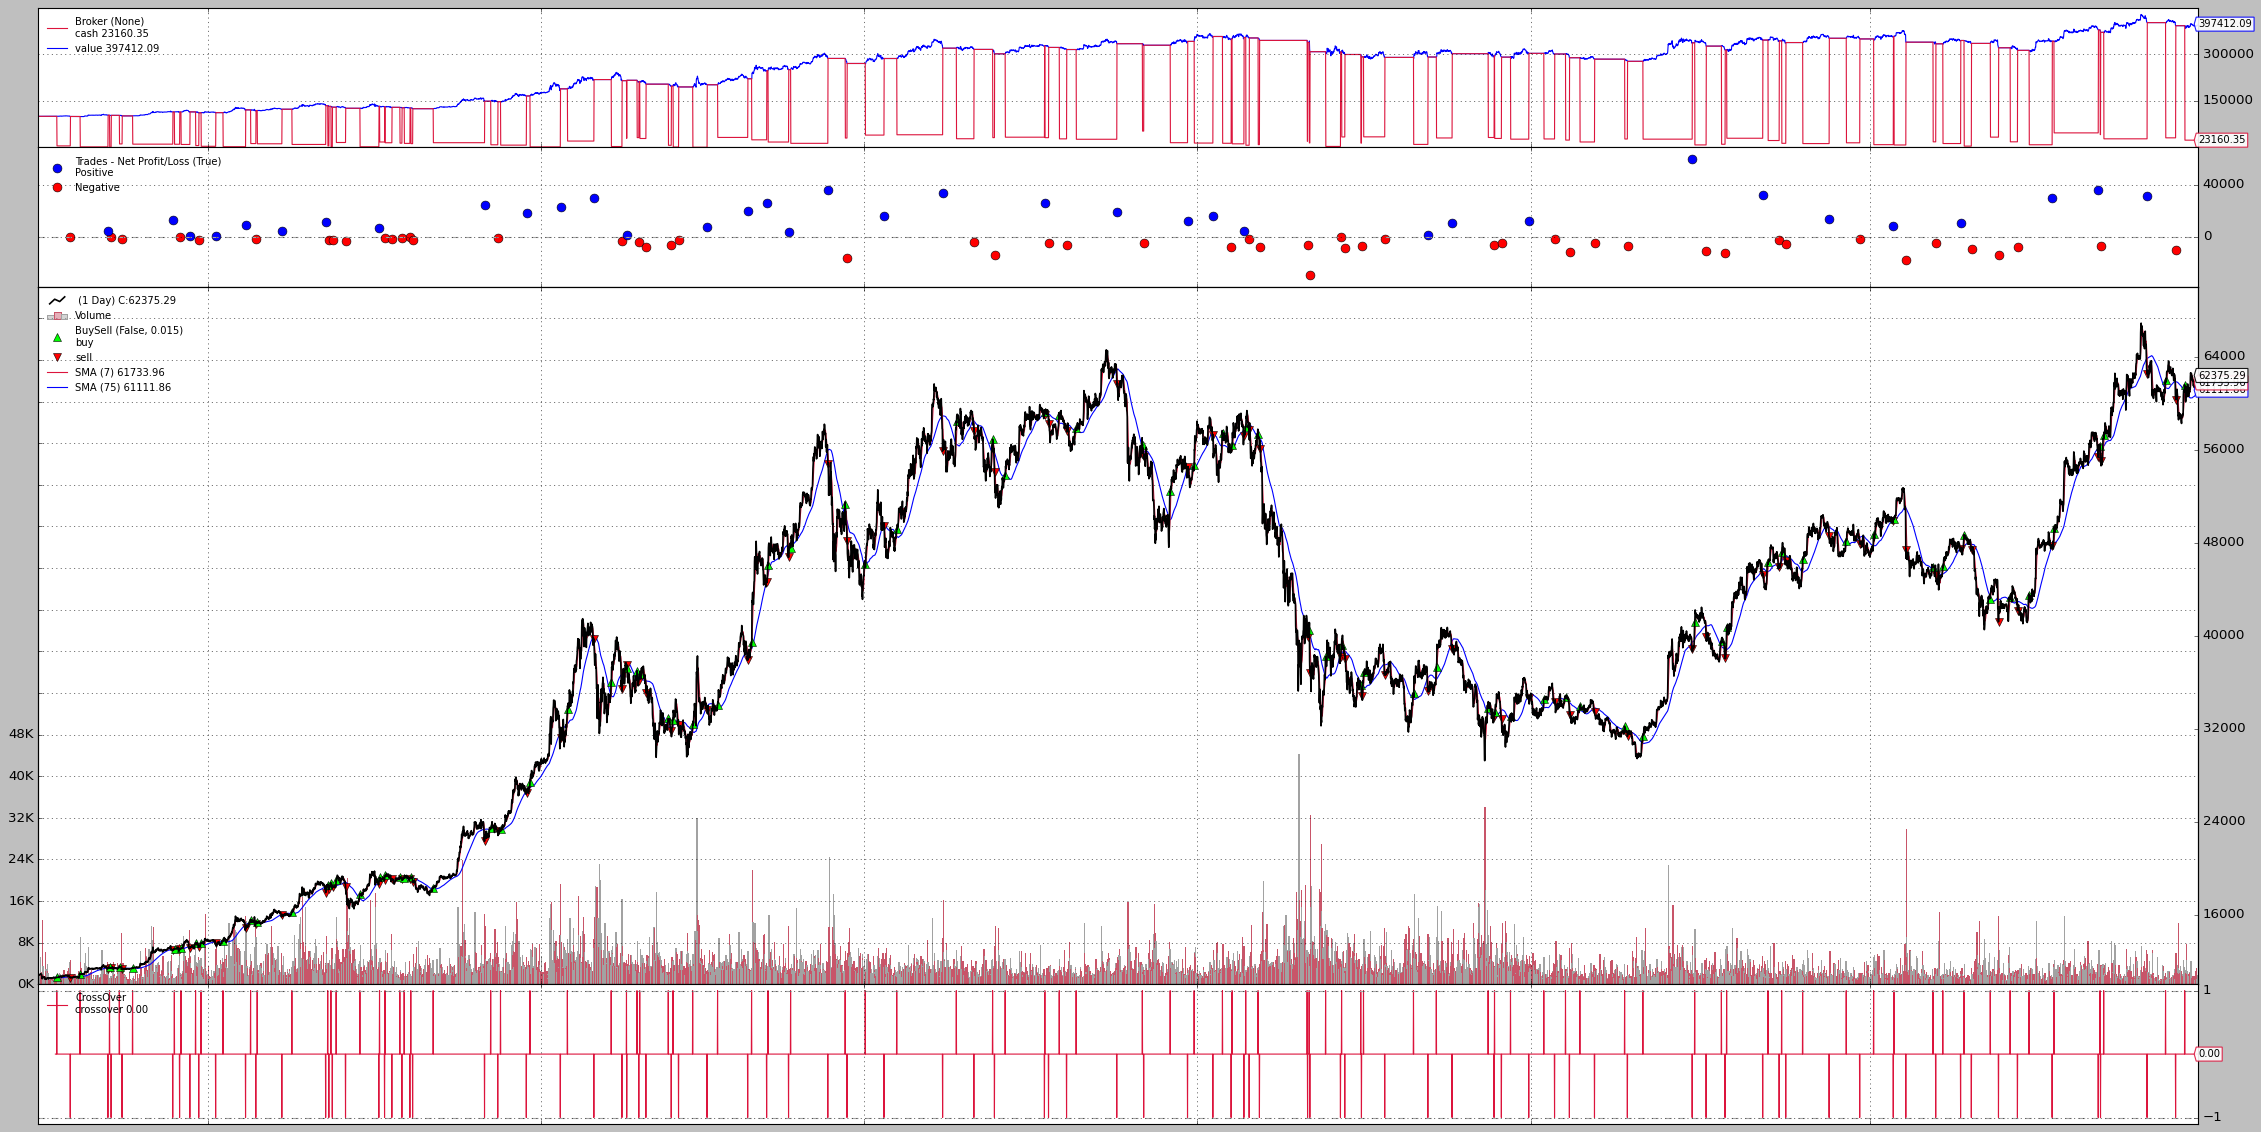

In [37]:
#mostra resultados com novos valores otimizados
results = backtest('smac', 
                   crypto, 
                   fast_period=fast_best, 
                   slow_period=slow_best,
                   plot=True,
                   verbose=False
                  )

## Acessando histórico de transações

Isso é feito definindo return_history = True.

### Estratégia Simples

In [38]:
results, history = backtest('smac', 
                               crypto, 
                               fast_period=fast_best, 
                               slow_period=slow_best,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

In [39]:
results

,strat_id,init_cash,buy_prop,sell_prop,fractional,slippage,single_position,commission,stop_loss,stop_trail,take_profit,execution_type,channel,symbol,allow_short,short_max,add_cash_amount,add_cash_freq,invest_div,fast_period,slow_period,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,75,1.379804,0.003484,1.406219,140.621943,249,7.302926,31309.2,"{'len': 3008, 'drawdown': 24.299299294520416, ...",23.454413,119,3.840352,297412.09,397412.09,90,0.4,36,53,16923.319167,16.923319,-5977.854717,-5.977855,59755.04,59.75504,-29707.44,-29.70744


Com os Valores otimizados a performance é 457,70%.

In [40]:
history.keys()

dict_keys(['orders', 'periodic', 'indicators'])

In [41]:
orders = history['orders']
orders

,strat_id,strat_name,dt,type,price,size,value,commission,pnl
0,0,fast_period7_slow_period75,2020-10-04 10:00:00,buy,10595.52,9,95359.68,0.0,0.00
1,0,fast_period7_slow_period75,2020-10-06 21:00:00,sell,10549.51,-9,95359.68,0.0,-414.09
2,0,fast_period7_slow_period75,2020-10-08 16:00:00,buy,10896.96,9,98072.64,0.0,0.00
3,0,fast_period7_slow_period75,2020-10-13 18:00:00,sell,11354.30,-9,98072.64,0.0,4116.06
4,0,fast_period7_slow_period75,2020-10-14 01:00:00,buy,11475.52,9,103279.68,0.0,0.00
...,...,...,...,...,...,...,...,...,...
174,0,fast_period7_slow_period75,2021-10-13 20:00:00,buy,57259.77,6,343558.62,0.0,0.00
175,0,fast_period7_slow_period75,2021-10-21 18:00:00,sell,62487.00,-6,343558.62,0.0,31363.38
176,0,fast_period7_slow_period75,2021-10-25 03:00:00,buy,61954.76,6,371728.56,0.0,0.00
177,0,fast_period7_slow_period75,2021-10-26 23:00:00,sell,60292.24,-6,371728.56,0.0,-9975.12


O valor final dos resultados pode ser calculado a partir da comissão e pnl (lucro e perda = profit e loss) de todas as transações fechadas (compradas e vendidas) no histórico:



In [42]:
r = results.squeeze()
r.final_value

397412.0899999998

In [43]:
r.init_cash + orders.pnl.sum() - orders.commission.sum()

392413.1899999998

### estratégia de sinal único com pesquisa de grade

In [44]:
results, history = backtest('smac', 
                               crypto, 
                               fast_period=[7,14,21], 
                               slow_period=[30,45,60],
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

In [45]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array(['fast_period7_slow_period30', 'fast_period7_slow_period45',
        'fast_period7_slow_period60', 'fast_period14_slow_period30',
        'fast_period14_slow_period45', 'fast_period14_slow_period60',
        'fast_period21_slow_period30', 'fast_period21_slow_period45',
        'fast_period21_slow_period60'], dtype=object))

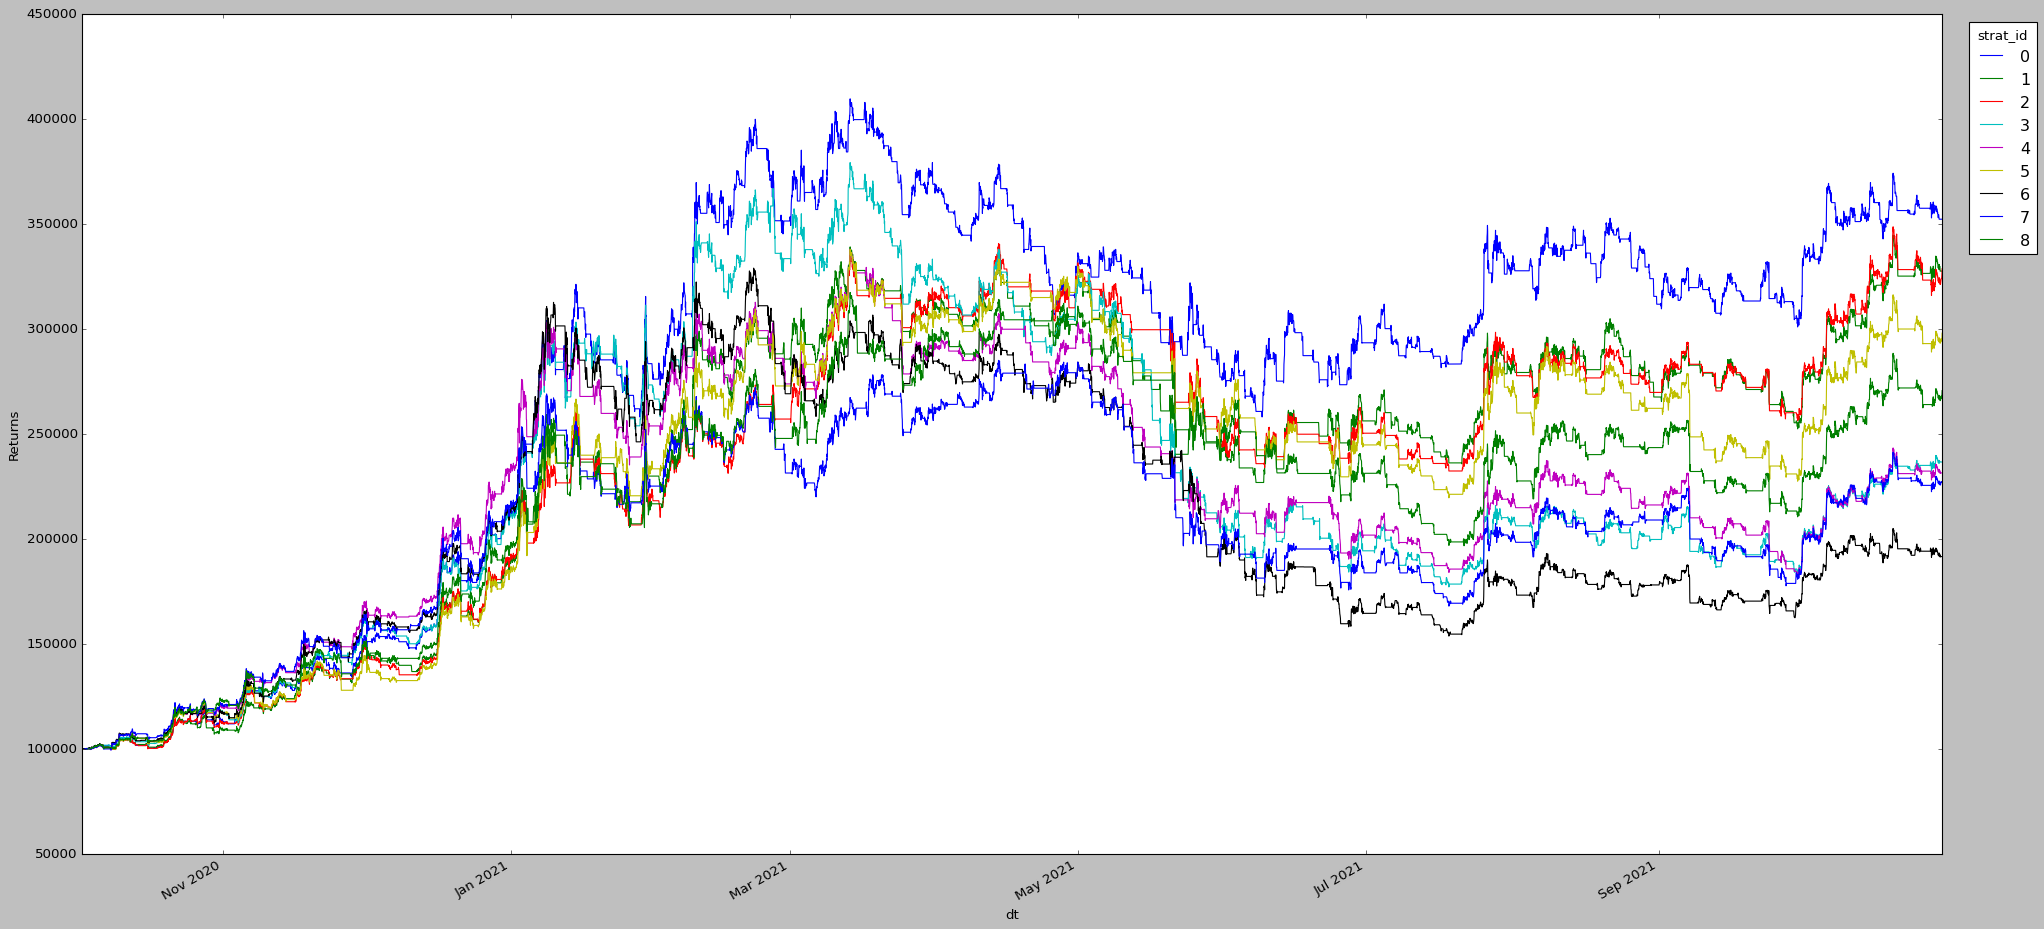

In [46]:
key = 'strat_id'
periodic = history['periodic']
g = periodic.set_index('dt').groupby(key)
axs = g.portfolio_value.plot(legend=key)
axs[0].set_ylabel('Returns')
axs[0].legend(g.groups, title=key, bbox_to_anchor=(1.01, 1), loc='upper left')

### estratégia multi sinal

In [47]:
# essa estratégia usa varios sinais(Cruzamento de média movel e RSI)
from fastquant import backtest

strats= {
       'smac': {
           'fast_period': 7, 
           'slow_period': 60
            },
        'rsi': {
            'rsi_upper': 70,
            'rsi_lower': 30 
        }
   }
results, history = backtest('multi', 
                               crypto, 
                               strats=strats,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

2021-10-31T00:00:00, ===Global level arguments===
2021-10-31T00:00:00, init_cash : 100000
2021-10-31T00:00:00, buy_prop : 1
2021-10-31T00:00:00, sell_prop : 1
2021-10-31T00:00:00, commission : 0
2021-10-31T00:00:00, stop_loss : 0
2021-10-31T00:00:00, stop_trail : 0
2021-10-31T00:00:00, take_profit : 0
===Strategy level arguments===
fast_period : 7
slow_period : 60
2021-10-31T00:00:00, ===Global level arguments===
2021-10-31T00:00:00, init_cash : 100000
2021-10-31T00:00:00, buy_prop : 1
2021-10-31T00:00:00, sell_prop : 1
2021-10-31T00:00:00, commission : 0
2021-10-31T00:00:00, stop_loss : 0
2021-10-31T00:00:00, stop_trail : 0
2021-10-31T00:00:00, take_profit : 0
===Strategy level arguments===
rsi_period : 14
rsi_upper : 70
rsi_lower : 30
2020-10-01T16:00:00, BUY CREATE, 10522.72
2020-10-01T16:00:00, Cash: 100000.0
2020-10-01T16:00:00, Price: 10522.72
2020-10-01T16:00:00, Buy prop size: 9.493752556382752
2020-10-01T16:00:00, Afforded size: 9.493752556382752
2020-10-01T16:00:00, Final siz

In [48]:
results

,strat_id,init_cash,buy_prop,sell_prop,smac.fractional,smac.slippage,smac.single_position,smac.commission,smac.stop_loss,smac.stop_trail,smac.take_profit,execution_type,smac.channel,smac.symbol,smac.allow_short,smac.short_max,smac.add_cash_amount,smac.add_cash_freq,smac.invest_div,smac.fast_period,smac.slow_period,rsi.fractional,rsi.slippage,rsi.single_position,rsi.commission,rsi.stop_loss,rsi.stop_trail,rsi.take_profit,rsi.channel,rsi.symbol,rsi.allow_short,rsi.short_max,rsi.add_cash_amount,rsi.add_cash_freq,rsi.invest_div,rsi.rsi_period,rsi.rsi_upper,rsi.rsi_lower,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,70,30,0.84626,0.002137,0.713484,71.348439,0,0.0,0.0,"{'len': 3167, 'drawdown': 36.32493382101467, '...",33.154437,129,3.520813,133091.24,233091.24,3,0.666667,2,0,2310.525,2.310525,0.0,0.0,3266.19,3.26619,0.0,0.0


usando estratégia multisinal a performance é 200,94%

In [49]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0]),
 array(['smac.fast_period7_slow_period60', 'rsi.rsi_upper70_rsi_lower30'],
       dtype=object))

In [50]:
from fastquant import backtest

strats= {
       'smac': {
           'fast_period': [7,14], 
           'slow_period': [30,60]
            },
        'rsi': {
            'rsi_upper': [70,80],
            'rsi_lower': [20,30] 
        }
   }
results, history = backtest('multi', 
                               crypto, 
                               strats=strats,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

A saída de streaming foi truncada nas últimas 5000 linhas.
2021-01-24T21:00:00, SELL EXECUTED, Price: 31673.26, Cost: 229608.05, Comm: 0.00, Size: -7.00
2021-01-25T06:00:00, BUY CREATE, 33496.22
2021-01-25T06:00:00, Cash: 249829.02999999997
2021-01-25T06:00:00, Price: 33496.22
2021-01-25T06:00:00, Buy prop size: 7.450973588943784
2021-01-25T06:00:00, Afforded size: 7.450973588943784
2021-01-25T06:00:00, Final size: 7
2021-01-25T07:00:00, BUY EXECUTED, Price: 33496.22, Cost: 234473.54, Comm: 0.00, Size: 7.00
2021-01-26T03:00:00, SELL CREATE, 32000.01
2021-01-26T04:00:00, SELL EXECUTED, Price: 31518.66, Cost: 234473.54, Comm: 0.00, Size: -7.00
2021-01-27T02:00:00, BUY CREATE, 31802.36
2021-01-27T02:00:00, Cash: 235986.10999999996
2021-01-27T02:00:00, Price: 31802.36
2021-01-27T02:00:00, Buy prop size: 7.4129831761026415
2021-01-27T02:00:00, Afforded size: 7.4129831761026415
2021-01-27T02:00:00, Final size: 7
2021-01-27T03:00:00, BUY EXECUTED, Price: 31802.36, Cost: 222616.52, Comm: 0.00,

In [51]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array(['smac.fast_period7_slow_period30', 'rsi.rsi_upper70_rsi_lower20',
        'rsi.rsi_upper70_rsi_lower30', 'rsi.rsi_upper80_rsi_lower20',
        'rsi.rsi_upper80_rsi_lower30', 'smac.fast_period7_slow_period60',
        'smac.fast_period14_slow_period30',
        'smac.fast_period14_slow_period60'], dtype=object))

In [52]:
results

,strat_id,init_cash,buy_prop,sell_prop,smac.fractional,smac.slippage,smac.single_position,smac.commission,smac.stop_loss,smac.stop_trail,smac.take_profit,execution_type,smac.channel,smac.symbol,smac.allow_short,smac.short_max,smac.add_cash_amount,smac.add_cash_freq,smac.invest_div,smac.fast_period,smac.slow_period,rsi.fractional,rsi.slippage,rsi.single_position,rsi.commission,rsi.stop_loss,rsi.stop_trail,rsi.take_profit,rsi.channel,rsi.symbol,rsi.allow_short,rsi.short_max,rsi.add_cash_amount,rsi.add_cash_freq,rsi.invest_div,rsi.rsi_period,rsi.rsi_upper,rsi.rsi_lower,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,3,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,1.508036,0.003808,1.610807,161.080670,231,3.977654,18714.85,"{'len': 2778, 'drawdown': 33.87154556445468, '...",31.670408,115,6.430672,351784.89,451784.89,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,1.370140,0.003460,1.391467,139.146738,4783,2.066928,8306.92,"{'len': 4783, 'drawdown': 42.798673719916444, ...",39.603794,200,2.700993,293590.09,393590.09,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,1.224803,0.003093,1.180207,118.020732,32,1.503040,5193.65,"{'len': 5210, 'drawdown': 38.48597362705928, '...",37.027045,217,28.268411,240349.49,340349.49,4,0.750000,3.0,0.0,17971.313333,17.971313,0.00,0.00000,23545.89,23.54589,0.00,0.00000
3,2,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,20,1.206578,0.003047,1.155068,115.506805,128,3.309285,11438.25,"{'len': 3185, 'drawdown': 26.537687110100425, ...",23.895803,132,5.677200,234202.83,334202.83,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,70,30,1.051181,0.002654,0.952154,95.215362,1582,7.924800,24624.51,"{'len': 3469, 'drawdown': 30.561339510815106, ...",28.802990,149,4.020929,186102.72,286102.72,3,0.666667,2.0,0.0,2240.955000,2.240955,0.00,0.00000,3127.05,3.12705,0.00,0.00000
5,6,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,20,1.011878,0.002555,0.903934,90.393418,4783,9.863249,30100.32,"{'len': 4783, 'drawdown': 39.08606929897262, '...",36.387585,200,4.127968,175076.21,275076.21,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,15,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,1.009787,0.002550,0.901403,90.140287,4709,15.922507,51984.85,"{'len': 4709, 'drawdown': 46.14759050739541, '...",42.423487,197,4.727555,174501.73,274501.73,4,0.500000,2.0,1.0,4032.160000,4.032160,-1087.37,-1.08737,7753.32,7.75332,-1087.37,-1.08737
7,5,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,70,30,0.846260,0.002137,0.713484,71.348439,0,0.000000,0.00,"{'len': 3167, 'drawdown': 36.32493382101467, '...",33.154437,129,3.520813,133091.24,233091.24,3,0.666667,2.0,0.0,2310.525000,2.310525,0.00,0.00000,3266.19,3.26619,0.00,0.00000
8,10,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,20,0.823119,0.002079,0.688437,68.843678,5462,18.511240,51738.51,"{'len': 5462, 'drawdown': 40.15666527047213, '...",38.018357,228,4.792498,127759.30,227759.30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,60,False,0.001,None,

### custom strategy

In [53]:
import numpy as np

#add a column which is a proxy buy/sell indicator for custom strategy
crypto["custom"] = crypto.close.pct_change()

In [54]:
results, history = backtest('custom', 
                                crypto, 
                                upper_limit=0.05, 
                                lower_limit=-0.05,
                                plot=False,
                                verbose=False,
                                return_history=True
                                )

===Strategy level arguments===
Upper limit:  0.05
Lower limit:  -0.05


In [55]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0]), array(['upper_limit0.05_lower_limit-0.05'], dtype=object))